# MNIST with CNN

* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

No need to flatten the MNIST data, as a CNN expects 2-dimensional data.

In [1]:
#perform standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F #add some efficiency
from torch.utils.data import DataLoader # load data in batches
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#MNIST >> TENSORS
transform = transforms.ToTensor() #define tranform 
# Load the MNIST data
#Load the training set
train_data = datasets.MNIST(root = 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train = True, download= True, transform=transform)
#Load test set
test_data = train_data = datasets.MNIST(root = 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train = False, download= True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
# Create loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define a convolutional model 
two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output

1. Extend the base Module class: 
2. Set up the convolutional layers with torch.nn.Conv2d()
    - Input channel (the grayscale color channel): 6 inputs 
    - Kernel size: 3x3 filter, step size = 1
    - The second layer take 6 input channels and deliver 16 output 
    - Output channels for feature extraction
    
   
3. Fully connected layers with torch.nn.Linear() <br>
The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be 
$\;(((28-2)/2)-2)/2 = 5.5\;$ which rounds down to 5 pixels per side
4. Define the forward method

Activations can be applied to the convolutions in one line using F.relu()</strong> and pooling F.max_pool2d()</strong>

In [7]:
#Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [8]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [9]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [10]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [11]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [12]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [13]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [14]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [18]:
# Define Loss funtion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
#Train the model
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.28406069  accuracy:  79.133%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01115547  accuracy:  95.200%
epoch:  2  batch:  600 [  6000/60000]  loss: 0.05564288  accuracy:  96.883%
epoch:  3  batch:  600 [  6000/60000]  loss: 0.00389622  accuracy:  98.067%
epoch:  4  batch:  600 [  6000/60000]  loss: 0.00719956  accuracy:  98.233%

Duration: 159 seconds


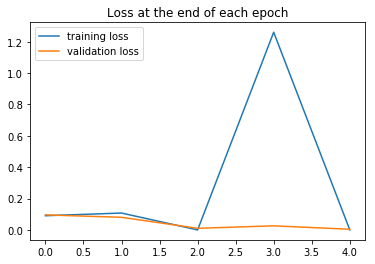

In [20]:
# Plot the loss acc comparisons
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
test_losses

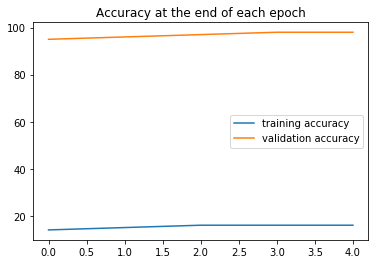

In [21]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
# Evaluate test data
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [23]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9824/10000 =  98.240%


In [24]:
#Dispaly confusion matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    0    0    0    2    3    0    4    5]
 [   0 1128    0    0    0    0    1    1    3    3]
 [   5    5 1029    8    0    1    0    6   40    1]
 [   0    0    0  993    0    7    0    0    5    8]
 [   0    1    0    0  981    0    0    1    3    5]
 [   0    0    0    2    0  871    0    0    2    1]
 [   2    1    0    0    1    8  954    0    7    1]
 [   0    0    3    7    0    1    0 1019    9    4]
 [   0    0    0    0    0    1    0    0  895    0]
 [   0    0    0    0    0    1    0    1    6  981]]


In [25]:
#Examine the misses 
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

176

In [26]:
# Display the first 10 index positions
misses[:10]

array([ 257,  290,  320,  321,  340,  381,  403,  445,  449,  495],
      dtype=int64)

In [27]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 257  290  320  321  340  381  403  445  449  495  582  591]
Label: [   8    8    9    2    5    3    8    6    3    8    8    8]
Guess: [   1    4    7    7    3    7    9    0    5    2    2    2]


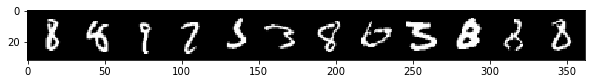

In [28]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

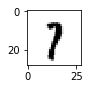

In [32]:
# Run a new image through the model 
# pass a single image through the model to obtain a prediction.
# Pick a number from 0 to 9999, assign it to "x", and we'll use that value to select a number from the MNIST test set.

x = 111
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");